100%|██████████| 500/500 [00:02<00:00, 202.69it/s]


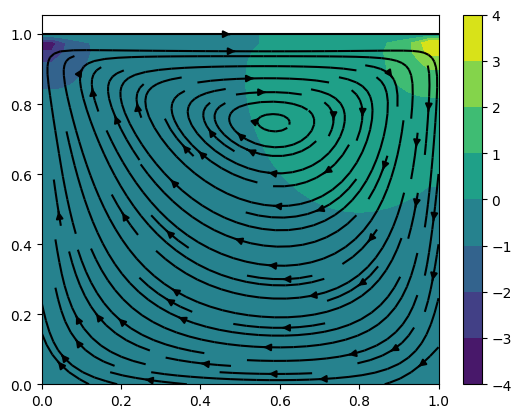

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


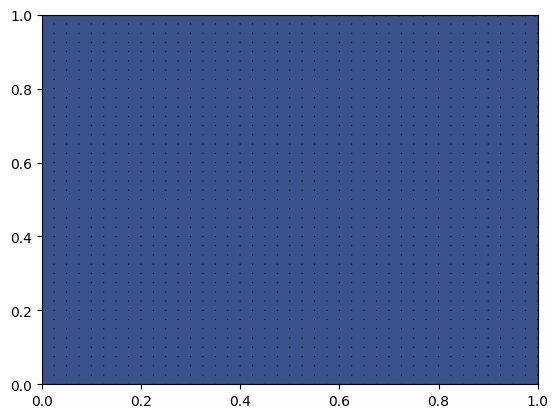

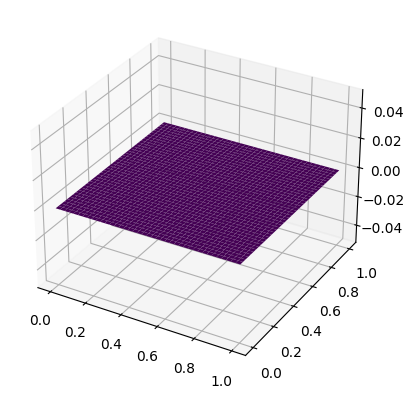

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# %matplotlib qt

N_POINTS = 41
DOMAIN_SIZE = 1.0
N_ITERATIONS = 500
TIME_STEP_LENGTH = 0.001
KINEMATIC_VISCOSITY = 0.1
DENSITY = 1.0
HORIZONTAL_VELOCITY_TOP = 1.0
N_PRESSURE_POISSON_ITERATIONS = 50
STABILITY_SAFETY_FACTOR = 0.5
history_u = []
history_v = []
history_p = []
def main():
    element_length = DOMAIN_SIZE/(N_POINTS+1)
    x = np.linspace(0.0,DOMAIN_SIZE,N_POINTS)
    y = np.linspace(0.0,DOMAIN_SIZE,N_POINTS)
    X,Y =   np.meshgrid(x,y)
    u_prev = np.zeros_like(X)
    v_prev = np.zeros_like(X)
    p_prev = np.zeros_like(X)
    def central_difference_x(f):
        diff = np.zeros_like(f)
        diff[1:-1,1:-1] =(
            f[1:-1,2:]
            -
            f[1:-1,0:-2]
        ) / (
            2*element_length
        )
        return diff
    def central_difference_y(f):
        diff = np.zeros_like(f)
        diff[1:-1,1:-1] =(
            f[2:,1:-1]
            -
            f[0:-2,1:-1]
        ) / (
                2*element_length
        )
        return diff
    def laplace(f):
        diff = np.zeros_like(f)
        diff[1:-1,1:-1] = (
            f[1:-1,0:-2]
            +
            f[0:-2,1:-1]
            -
            4
            *
            f[1:-1,1:-1]
            +
            f[1:-1,2:]
            +
            f[2:,1:-1]
        )/(
            element_length**2
        )
        return diff
    maximum_possible_time_step_length = (
        0.5*element_length**2/KINEMATIC_VISCOSITY
    )
    if TIME_STEP_LENGTH >STABILITY_SAFETY_FACTOR* maximum_possible_time_step_length:
        raise RuntimeError("Stability is not guarenteed")
    for _ in tqdm(range(N_ITERATIONS)):
        d_u_prev__d_x = central_difference_x(u_prev)
        d_u_prev__d_y = central_difference_y(u_prev)
        d_v_prev__d_x = central_difference_x(v_prev)
        d_v_prev__d_y = central_difference_y(v_prev)
        laplace_u_prev = laplace(u_prev)
        laplace_v_prev = laplace(v_prev)
        u_tent = (
            u_prev
            +
            TIME_STEP_LENGTH*(
                -
                (
                    u_prev+d_u_prev__d_x
                    +
                    v_prev*d_u_prev__d_y
                )
                +
                KINEMATIC_VISCOSITY*laplace_u_prev
            )
        )
        v_tent = (
            v_prev
            +
            TIME_STEP_LENGTH*(
                -
                (
                    u_prev+d_v_prev__d_x
                    +
                    v_prev*d_v_prev__d_y
                )
                +
                KINEMATIC_VISCOSITY*laplace_v_prev
            )
        )
        u_tent[0,:] = 0.0
        u_tent[:,0] = 0.0
        u_tent[:,-1] = 0.0
        u_tent[-1,:] = HORIZONTAL_VELOCITY_TOP

        v_tent[0,:] = 0.0
        v_tent[:,0] = 0.0
        v_tent[:,-1] = 0.0
        v_tent[-1,:] =0.0

        d_u_tent__d_x = central_difference_x(u_tent)
        d_v_tent__d_y = central_difference_y(v_tent)

        rhs = (
            DENSITY/TIME_STEP_LENGTH
            *
            (
                d_u_tent__d_x
                +
                d_v_tent__d_y
            )
        )

        for _ in range(N_PRESSURE_POISSON_ITERATIONS):
            p_next = np.zeros_like(p_prev)
            p_next[1:-1,1:-1]=1/4 * (
                +
                p_prev[1:-1,0:-2]
                +
                p_prev[0:-2,1:-1]
                +
                p_prev[1:-1,2:]
                +
                p_prev[2:,1:-1]
                -
                element_length**2
                *
                rhs[1:-1,1:-1]
            )
            p_next[:,-1] = p_next[:,-2]
            p_next[0,:] = p_next[1,:]
            p_next[:,0] = p_next[:,1]
            p_next[-1,:] = 0
            p_prev = p_next
        d_p_next__d_x = central_difference_x(p_next)
        d_p_next__d_y = central_difference_y(p_next)
        u_next = (
            u_tent
            -
            TIME_STEP_LENGTH / DENSITY
            *
            d_p_next__d_x
        )
        v_next = (
            v_tent
            -
            TIME_STEP_LENGTH / DENSITY
            *
            d_p_next__d_y
        )
        u_next[0,:] = 0.0
        u_next[:,0] = 0.0
        u_next[:,-1] = 0.0
        u_next[-1,:] = HORIZONTAL_VELOCITY_TOP

        v_next[0,:] = 0.0
        v_next[:,0] = 0.0
        v_next[:,-1] = 0.0
        v_next[-1,:] =0.0

        u_prev = u_next
        v_prev = v_next
        p_prev = p_next
        history_u.append(u_next)
        history_v.append(v_next)
        history_p.append(p_next)

    show([X,Y,u_next,v_next,p_next])
    return [X,Y,u_next,v_next,p_next]

def show(args):
    X,Y,u_next,v_next,p_next = args
    plt.figure()
    plt.contourf(X,Y,p_next)
    plt.colorbar()

    #plt.quiver(X,Y,u_next,v_next,color = "black")
    plt.streamplot(X,Y,u_next,v_next,color = "black")
    plt.show()

X,Y,u_next,v_next,p_next = main()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# 定义函数 main() 和其他参数，与之前提供的代码相同...

# 以下为更新数据并绘制动态图的部分
fig, ax = plt.subplots()
x = np.linspace(0.0,DOMAIN_SIZE,N_POINTS)
y = np.linspace(0.0,DOMAIN_SIZE,N_POINTS)
X,Y =   np.meshgrid(x,y)
# 生成一个初始的等高线图和矢量场，p_prev 是初始的压力场数据，u_prev 和 v_prev 是初始的速度场数据
contour_plot = ax.contourf(X, Y, history_p[0],cmap = "viridis")

quiver_plot = ax.quiver(X, Y, history_u[0], history_v[0], color="black")

def update(frame):
    # 更新等高线图数据和矢量场数据
    global contour_plot,quiver_plot
    #contour_plot.set_array(history_p[frame].ravel())
    contour_plot.collections[0].remove()
    contour_plot = ax.contourf(X, Y, history_p[frame],cmap = "viridis")
    #contour_plot.set_array(history_p[frame].ravel())
    quiver_plot.remove()
    quiver_plot = ax.quiver(X, Y,  history_u[frame], history_v[frame],color="red",scale = 3)
    ax.set_title(f"迭代次数：{frame}次")

    return contour_plot, quiver_plot

# 使用 FuncAnimation 来创建动态图
animation = FuncAnimation(fig, update, frames=N_ITERATIONS, interval=1)
# animation.save("N-S方程数值模拟.gif",fps = 10)
# 显示动态图

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

# 定义函数 main() 和其他参数，与之前提供的代码相同...

# 以下为更新数据并绘制动态3D图的部分
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 生成一个初始的3D等高线图和矢量场，p_prev 是初始的压力场数据，u_prev 和 v_prev 是初始的速度场数据
contour_plot = ax.plot_surface(X, Y,  history_p[1],cmap = "viridis")

def update(frame):
    global contour_plot
    # 更新3D等高线图数据
    contour_plot.remove()
    contour_plot = ax.plot_surface(X, Y, history_p[frame],cmap = "viridis")


    return contour_plot,

# 使用 FuncAnimation 来创建动态3D图
animation = FuncAnimation(fig, update, frames=N_ITERATIONS, interval=1)
# animation.save("N-S方程数值模拟2.gif",fps = 10)
# 显示动态3D图
# plt.show() 作者：永远的纸条 https://www.bilibili.com/read/cv26053888/ 出处：bilibili